# CS M148 Project 2 - Binary Classification Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a **patient is suffering from heart disease** based on a host of potential medical factors.

**DEFINITIONS**

**Binary Classification:** In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

**Supervised Learning:** This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
- **age:** Age in years
- **sex:** (1 = male; 0 = female)
- **cp:** Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)
- **trestbps:** Resting blood pressure (in mm Hg on admission to the hospital)
- **cholserum:** Cholestoral in mg/dl
- **fbs** Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- **restecg:** Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))
- **thalach:** Maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeakST:** Depression induced by exercise relative to rest
- **slope:** The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)
- **ca:** Number of major vessels (0-4) colored by flourosopy
- **thal:** 1 = normal; 2 = fixed defect; 3 = reversable defect
- **sick:** Indicates the presence of Heart disease (True = Disease; False = No disease)

`sick` is the label that you will be predicting.

## Loading Essentials and Helper Functions 

In [1]:
# Here are a set of libraries we imported to complete this assignment. 
# Feel free to use these or equivalent libraries for your implementation
# If you can run this cell without any errors, you're ready to go.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 

import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from matplotlib import pyplot

import os
import itertools
import random 

%matplotlib inline

random.seed(148)

In [2]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Part 1. Load the Data and Analyze

Let's load our dataset so we can work with it (correct the path if your notebook is in a different directory than the .csv file).

In [4]:
# load and take a random sample
data = pd.read_csv('heartdisease.csv').sample(frac=1).reset_index(drop=True)

### Question 1.1 

Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method, the describe method, and the info method to display some of the rows so we can visualize the types of data fields we'll be working with.

In [5]:
# Your code here
# You may use separate cells if you'd like (one for `head`, one for `describe`, etc.)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,59,1,0,170,326,0,0,140,1,3.4,0,0,3,True
1,49,1,2,120,188,0,1,139,0,2.0,1,3,3,True
2,38,1,2,138,175,0,1,173,0,0.0,2,4,2,False
3,52,1,0,112,230,0,1,160,0,0.0,2,1,2,True
4,47,1,0,110,275,0,0,118,1,1.0,1,1,2,True


In [6]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  sick      303 non-null    bool   
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


### Question 1.2
Sometimes data will be stored in different formats (e.g., string, date, boolean), but many learning methods work strictly on numeric inputs. Call the info method to determine the datafield type for each column. Are there any that are problemmatic and why?

[Use this area to describe any fields you believe will be problemmatic and why] E.g., All the columns in our dataframe are numeric (either int or float), however our target variable 'sick' is a boolean and may need to be modified.

**1.2 answer**

The information stored in:
- Chest pain type (`cp`)
    - 0 = asymptomatic
    - 1 = atypical angina
    - 2 = non-anginal pain
    - 3 = typical angina
- slope of the peak exercise (`slope`)
    - 0 = downsloping
    - 1 = flat
    - 2 = upsloping
- Resting electrocardiographic results (`restecg`)
    - 0= showing probable or definite left ventricular hypertrophy by Estes' criteria
    - 1 = normal
    - 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
- `thal`
    - 1 = normal
    - 2 = fixed defect
    - 3 = reversable defect
are all non-binary values which are ordinal.  This data must be 1 hot encoded as to remove the bias and errors it might create because of it's ordinal nature.

Furthermore, the `sick` column is a `bool` which is `True` & `False` and must be converted to binary.


### Question 1.3
Determine if we're dealing with any null values. If so, report which columns.

In [8]:
data[data.isnull().any(axis=1)].head() # no nulls anywhere

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick


### Question 1.4
Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean `sick` variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original `sick` datafield from the dataframe.

In [9]:
data['sick'].replace(True, 1,inplace=True)
data['sick'].replace(False, 0,inplace=True)

In [10]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,59,1,0,170,326,0,0,140,1,3.4,0,0,3,1
1,49,1,2,120,188,0,1,139,0,2.0,1,3,3,1
2,38,1,2,138,175,0,1,173,0,0.0,2,4,2,0
3,52,1,0,112,230,0,1,160,0,0.0,2,1,2,1
4,47,1,0,110,275,0,0,118,1,1.0,1,1,2,1


### Question 1.5
Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to get a feel of how each variable performs (for example, is it a binary, or limited selection, or does it follow a gradient)? 

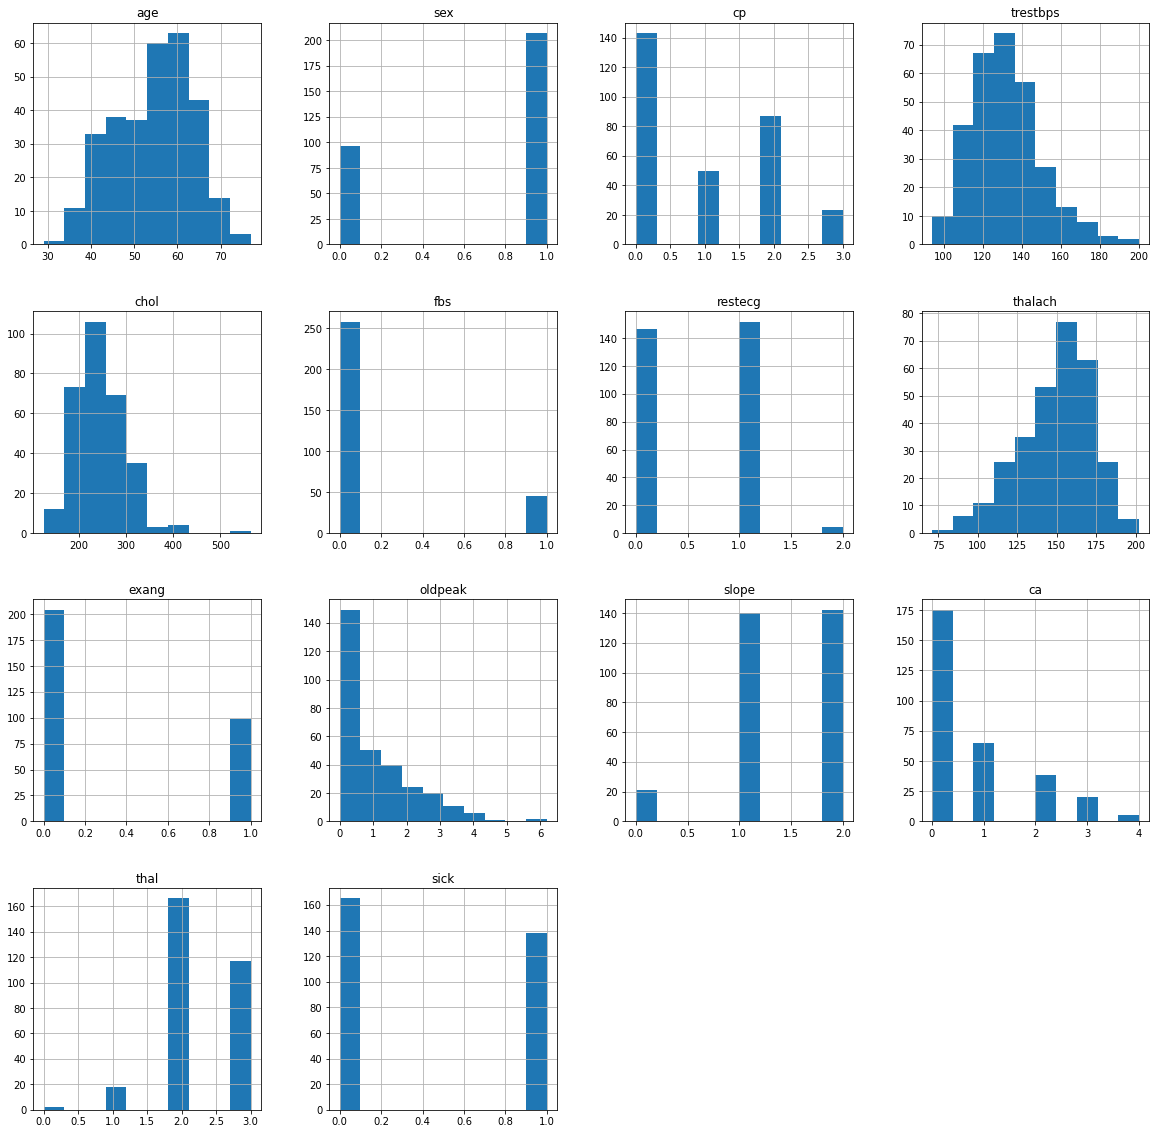

In [11]:
data.hist(figsize=(20,20))
plt.show()

**1.5 response**
- Binary
    - sex
    - fbs
    - exang
- Gradient
    - age
    - trestbps
    - chol
    - thalach
    - oldpeak
- Limited Selection
    - cp
    - restecg
    - slope
    - thal
    - ca

### Question 1.6
We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results.

In [12]:
data['sick'].value_counts()

0    165
1    138
Name: sick, dtype: int64

<AxesSubplot:>

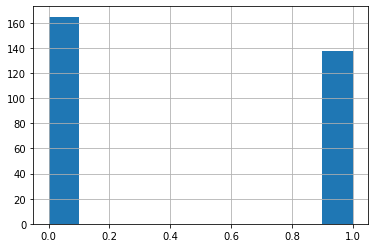

In [13]:
data['sick'].hist()

[Include description of findings here] E.g., As we can see, our sample contains xxx healthy individuals and yyy sick individuals, which reflects a [your conclusion here].

**1.6 answer**

There are 165 healthy individuals and 138 sick individuals, which reflects a fairly balanced dataset with a slight bias toward healthy individuals.

### Question 1.7 
Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

[You answer here] E.g., artificially inflating numbers to balance a dataset may result in xxx. Concurrently showing statistically uncommon events as likely may result in yyy.

**1.7 answer**

If you artificially balance the dataset then you could create datapoints which would be completely incorrect.  Furthermore, creating more datapoints from an already existing dataset will tend toward your results overfitting to the dataset because you must create new datapoints for the case which is more rare.

### Question 1.8
Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations (get some domain knowledge). Intuitively, why do you think some variables correlate more highly than others? Also discuss some pairs of variables that have very little correlation and why this might be the case for them.

Hint: one possible approach you can use the `sns.heatmap()` function to map the corr() method. Note: if your heatmap is not entirely visible, [this link](https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986) may be helpful in solving the issue.

<AxesSubplot:>

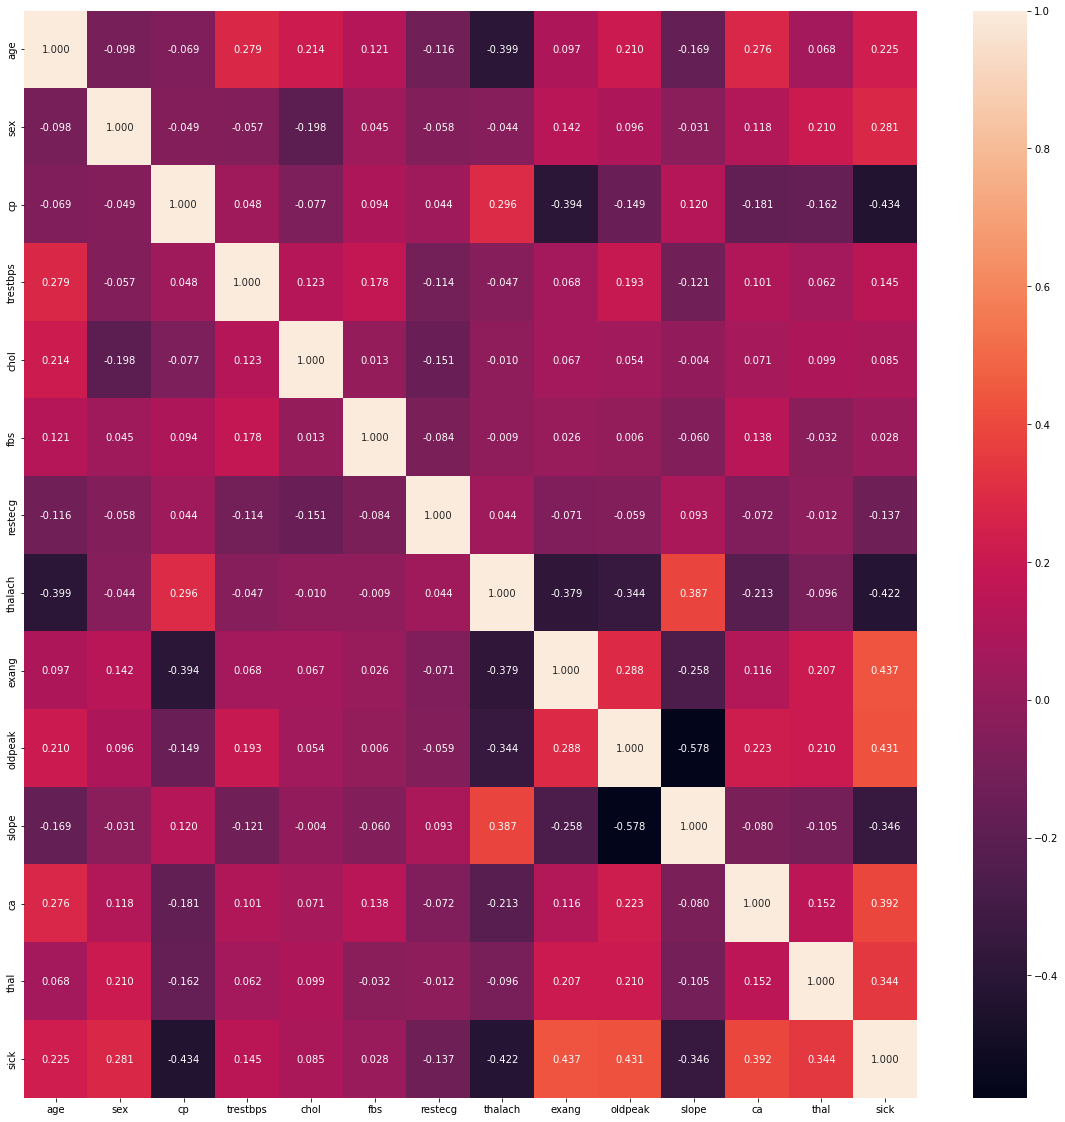

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),annot=True,fmt='.3f')

Do some research on the variables to understand why they may relate to the observed corellations (get some domain knowledge).

Intuitively, why do you think some variables correlate more highly than others? 

Also discuss some pairs of variables that have very little correlation and why this might be the case for them.

[Discuss correlations here] E.g., We find the the strongest direct correlation between the presence of exercise induced angina `exang` (also a binary), and depression induced by exercise relative to rest `oldpeakST` indicates a strong direct correlation. Both of these are understandable as heart failure under conditions of duress is a clear indication of heart disease. Conversely, maximum heart rate achieved is inversely correlated, likely as a healthy heart is unable to achieve a high heart rate.

**1.8 answer**

We also find that there is a positive correlation between Number of major vessels colored by flourosopy`ca` and `sick`.

We find that this might be a misleading correlation because this test might be done on individuals who are showing symptoms of heart disease.

Also we find a lower positive correlation between `sex` and `age` with `sick`.

This could be because older men are more likely to have heart problems.

There is relatively low correlation between the slope of the peak exercise ST segment `slope` and Cholestoral in mg/dl `chol`.

This could be because there is a even spread of the `slope` of the peak exercise segment at all levels of cholestoral.

Chest pain `cp` and `slope` have a negative correlation with `sick`.

This could because no chest pain `0` is the least severe and anigma `3` is the most severe.


## Part 2. Prepare the Data

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

We're going to ask you to prepare 2 batches of data:
1. Raw numeric data that hasn't gone through any additional pre-processing.
2. Data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Question 2.1
Save the target column as a separate array and then drop it from the dataframe. 

In [15]:
sick = data['sick'] # target column
data.drop(columns=['sick'],axis=1,inplace=True) # drop target column

In [16]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,59,1,0,170,326,0,0,140,1,3.4,0,0,3
1,49,1,2,120,188,0,1,139,0,2.0,1,3,3
2,38,1,2,138,175,0,1,173,0,0.0,2,4,2
3,52,1,0,112,230,0,1,160,0,0.0,2,1,2
4,47,1,0,110,275,0,0,118,1,1.0,1,1,2


In [17]:
sick.head()

0    1
1    1
2    0
3    1
4    1
Name: sick, dtype: int64

### Question 2.2
Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 85% of your total dataframe (hint: use the `train_test_split` method). Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(data, sick, train_size=0.85)

In [19]:
(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

((257, 13), (46, 13), (257,), (46,))

### Question 2.3
In lecture we learned about K-Nearest Neighbor. One thing we noted was because KNN rlies on Euclidean distance, they are highly sensitive to the relative magnitude of different features. Let's see that in action! Implement a KNN algorithm on our data (use `scikit-learn`) and report the results. For this initial implementation simply use the default settings. Report on the accuracy of the resulting model.

In [20]:
knn = KNeighborsClassifier()
knn.fit(x_train.values, y_train.values)
y_train_pred = knn.predict(x_train.values)
y_test_pred = knn.predict(x_test.values)
print(f'train accuracy: {metrics.accuracy_score(y_train, y_train_pred)}')
print(f'test accuracy: {metrics.accuracy_score(y_test, y_test_pred)}')

train accuracy: 0.7509727626459144
test accuracy: 0.6521739130434783


### Question 2.4 
Now implement a pipeline of your choice to transform the data. You can opt to handle null values and categoricals however you wish, however please scale your numeric features using standard scaler. Refer to Project 1 for a example pipeline that you can mimic.

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

categoricalFeatures = ['cp', 'restecg', 'slope', 'thal', 'ca']
numericalColumns = data.drop(columns=categoricalFeatures, axis=1) # drop categorical features
numericalFeatures = list(numericalColumns) # get numerical features list
numericPipeline = Pipeline([('std_scaler', StandardScaler())]) # make pipeline for numerical features
full_pipeline = ColumnTransformer([
        ("num", numericPipeline, numericalFeatures),
        ("cat", OneHotEncoder(), categoricalFeatures),
    ]) # combine pipelines
preparedData = full_pipeline.fit_transform(data) # fit transform

### Question 2.5
Now split your pipelined data into an 85/15 split and run the same KNN as you did previously. Report its accuracy, and discuss the implications of the different results you are obtaining.

In [22]:
x_train, x_test, y_train, y_test = train_test_split(preparedData, sick,train_size=0.85, random_state=42)
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_train_pred =knn.predict(x_train)
y_test_pred = knn.predict(x_test)
print(f'train accuracy: {metrics.accuracy_score(y_train, y_train_pred)}')
print(f'test accuracy: {metrics.accuracy_score(y_test, y_test_pred)}')

train accuracy: 0.8910505836575876
test accuracy: 0.8478260869565217


**2.5 answer**

Because we 1 hot encoded the categorical data our model is not assuming that there is a reason for the ordering in these categorical data.  This improved the performance because the model is not making assumptions about those columns.  The test accuracy increased by `26.7%`.

### Question 2.6 Hyperparameter Optimization
As we saw in lecture, the KNN Algorithm includes an `n_neighbors` attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now letting `n` take on the values 1, 2, 3, 5, 7, 9, 10, 20, 50, 75, and 100. Run your model for each value and report the accuracy for each. Then, create a plot of accuracy versus `n_neighbors` and discuss how and why the accuracy changes as `n_neighbors` changes.

HINT: leverage Python's ability to loop to run through the array and generate results so that you don't need to manually code each iteration.

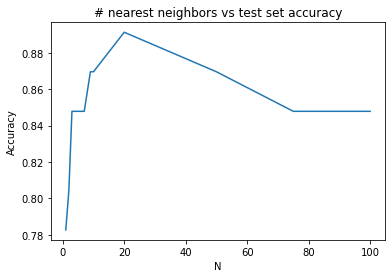

In [23]:
testSetAccuracies = []
nVals = [1,2,3,5,7,9,10,20,50,75,100]
for i in nVals:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    y_train_pred = knn.predict(x_train)
    y_test_pred = knn.predict(x_test)
    testSetAccuracies.append(metrics.accuracy_score(y_test, y_test_pred))

plt.xlabel('N')
plt.ylabel('Accuracy')
plt.title('# nearest neighbors vs test set accuracy')
plt.plot(nVals, testSetAccuracies)
plt.show()

**2.6 answer**

With a small `n_neighbors` value the model performs very poorly because of overfitting to the train data but as we increase the number of neighbors being looked at we get a better model.  As we have larger and larger values for `n_neighbors` we can see the accuracy decrease because we are underfitting the data.  This underfits the data because we are looking at too many data points and not getting enough information from the datapoints.

## Part 3. Additional Learning Methods
So we have a model that seems to work well. But let's see if we can do better! To do so we'll employ multiple learning methods and compare results. Throughout this part, use the data that was produced by your pipeline earlier.

### Linear Decision Boundary Methods
We'll spend some time exploring logistic regression and SVM methods.

### Question 3.1 Logistic Regression
Let's now try a classifier, we introduced in lecture, one that's well known for handling linear models: logistic regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.  Implement a logistic regression classifier on your data with the default settings. Report accuracy, precision, recall, and F1 score and plot a confusion matrix.

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

lr = LogisticRegression()
logisticRegModel = lr.fit(x_train, y_train)
y_test_pred = logisticRegModel.predict(x_test)
accuracy = accuracy_score(y_test, y_test_pred)
precision =  precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
F1Score = f1_score(y_test, y_test_pred)
print(f'{accuracy=}\n{precision=}\n{recall=}\n{F1Score=}')

accuracy=0.8695652173913043
precision=0.8571428571428571
recall=0.8571428571428571
F1Score=0.8571428571428571


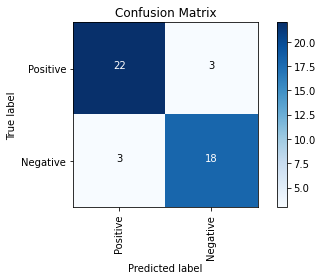

In [25]:
draw_confusion_matrix(y_test, y_test_pred, ("Positive", "Negative"))

### Question 3.2
Discuss what each measure (accuracy, precision, recall, and F1 score) is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.


**3.2 answer**

accuracy $=\frac{TP + TN}{TP + FP + TN + FN}$

- Accuracy is the number of correctly predicted data points over the total data points.
- This is useful when your dataset is balanced between FP and FN.

precision $=\frac{TP}{TP + FP}$

- Precision is the ratio of true positive observations to all the positive observations.
- This is useful when we have a very high cost of a false positive (e.g. guilty sentence).

recall $=\frac{TP}{TP + FN}$

- Recall is the ratio of true positive obsrvations to all observations.
- This is useful when the cost of false negatives is very high (e.g. cancer detection).

F1 score $=2 \cdot \frac{ ( Precision \cdot Recall )}{Precision + Recall}$

- F1 score is useful when the data set is not evenly distributed.  It gives a balanced evaluation of the model's accuracy.


### Question 3.3
Graph the ROC curve of the logistic regression model.

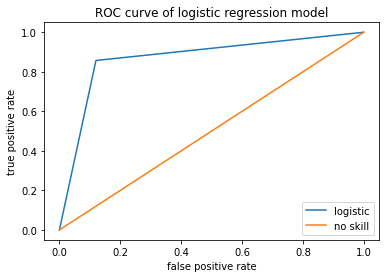

In [26]:
falsePositiveRate, truePositiveRate, _ = metrics.roc_curve(y_test, y_test_pred)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve of logistic regression model")
plt.plot(falsePositiveRate,truePositiveRate, label="logistic")
plt.plot([0,1],[0,1], label="no skill")
plt.legend()
plt.show()

### Question 3.4
Describe what an ROC curve is and what your ROC graph output is showing.

**3.4 answer**

A ROC (Receiver operating characteristic) curve is the true positive rate vs the false positive rate.  We can see that because it is concave down and above the no skill line that we are predicting better than randomly guessing.  Because we have a larger area under the curve than 0.5 that also says that we are doing better than randomly guessing. 

### Question 3.5
Let's tweak a few settings. Set your solver to `newton-cg`, your `max_iter=4`, and `penalty='none'`, and rerun your model. Report out the same metrics (the 4 + confusion matrix) as before. How do your results change?

In [27]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

lr = LogisticRegression(solver="newton-cg", max_iter=4, penalty="none")
logisticRegModel = lr.fit(x_train, y_train)
y_test_pred2 = logisticRegModel.predict(x_test)
accuracy2 = accuracy_score(y_test, y_test_pred2)
precision2 =  precision_score(y_test, y_test_pred2)
recall2 = recall_score(y_test, y_test_pred2)
F1Score2 = f1_score(y_test, y_test_pred2)
print(f'{accuracy2=}\n{precision2=}\n{recall2=}\n{F1Score2=}')

accuracy2=0.8478260869565217
precision2=0.8181818181818182
recall2=0.8571428571428571
F1Score2=0.8372093023255814


/Users/williamrandall/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


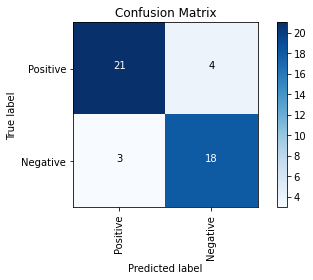

In [28]:
draw_confusion_matrix(y_test, y_test_pred2, ("Positive", "Negative"))

**3.5 answer** TODO check

- accuracy
- precision
- F1 Score

Were all better in the default model.

### Question 3.6
Did you notice that when you ran the previous model you got the following warning: `ConvergenceWarning: The max_iter was reached which means the coef_ did not converge.` Check the documentation and see if you can implement a fix for this problem, and again report your results.

Note: if you did not get a warning, which might happen to those running this notebook in VSCode, please try running the following code, as described [here](https://github.com/microsoft/vscode-jupyter/issues/1312):
```
import warnings
warnings.simplefilter(action="default")
```

In [29]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

lr = LogisticRegression(solver="newton-cg", max_iter=100, penalty="none")
logisticRegModel = lr.fit(x_train, y_train)
y_test_pred3 = logisticRegModel.predict(x_test)
accuracy3 = accuracy_score(y_test, y_test_pred3)
precision3 =  precision_score(y_test, y_test_pred3)
recall3 = recall_score(y_test, y_test_pred3)
F1Score3 = f1_score(y_test, y_test_pred3)
print(f'{accuracy3=}\n{precision3=}\n{recall3=}\n{F1Score3=}')

accuracy3=0.8260869565217391
precision3=0.782608695652174
recall3=0.8571428571428571
F1Score3=0.8181818181818182


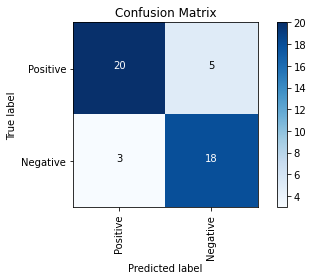

In [30]:
draw_confusion_matrix(y_test, y_test_pred3, ("Positive", "Negative"))

### Question 3.7
Explain what you changed and why this fixed the `ConvergenceWarning` problem. Are there any downsides of your fix? How might you have harmed the outcome instead? What other parameters you set may be playing a factor in affecting the results?

**3.7 answer**

I fixed the warning by increasing `max_iter` to `100`.  Because `max_iter` was low we were not able to get to maximize the log likelihood.

The downside to this fix is it will take longer to run, and it gave a worse result as seen in the lower F1 Score.

I think that not having a penalty makes the model perform poorly.

### Question 3.8
Rerun your logistic classifier, but modify the `penalty='l1'`, `solver='liblinear'` and again report the results.


In [31]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

lr = LogisticRegression(solver="liblinear", max_iter=100, penalty="l1")
logisticRegModel = lr.fit(x_train, y_train)
y_test_pred4 = logisticRegModel.predict(x_test)
accuracy4 = accuracy_score(y_test, y_test_pred4)
precision4 =  precision_score(y_test, y_test_pred4)
recall4 = recall_score(y_test, y_test_pred4)
F1Score4 = f1_score(y_test, y_test_pred4)
print(f'{accuracy4=}\n{precision4=}\n{recall4=}\n{F1Score4=}')

accuracy4=0.8695652173913043
precision4=0.8571428571428571
recall4=0.8571428571428571
F1Score4=0.8571428571428571


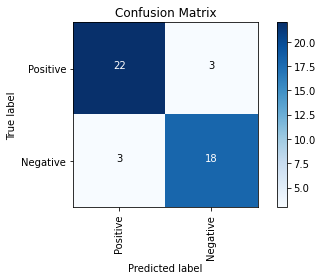

In [32]:
draw_confusion_matrix(y_test, y_test_pred4, ("Positive", "Negative"))

### Question 3.9
Explain what what the two solver approaches are, and why the model with `liblinear` and `l1` penalty likely produced the optimal outcome.

**3.9 answer**

I think that having `liblinear` and `l1` produced a better outcome than the previous test because:

- `newton-cg` minimize the cost function by using only the 1st and 2nd partial derivatives.
- `liblinear` will use the coordinate descent algorithm to iteratively get an approximiate minimization following coordinate axes or hyperplanes.
- `l1` penalty is a regularization term which prevents our model from overfitting to the test set.  It will give us a better outcome on the test set.

### Question 3.10
We also played around with different penalty terms (none, L1 etc.) Describe what the purpose of a penalty term is and the difference between L1 and L2 penalties.

**3.10 answer**

- A penalty term gives bias to our model.
- `l1` is lasso (Least Absolute Shrinkage and Selection Operator) regression
    - It adds squared magnitude of coefficient as penalty term to the loss function.
    - `l1` shrinks less imoprtant feature coefficients to zero.  This removes some features.  It works well for feature slection when we have a lot of features.
- `l2` is ridge regression
    - It adds adds absolute value of magnitude of coefficient as penalty term to the loss function.
    - `l2` shrinks less imoprtant features close to zero but all variables affect the model.

### Question 3.11 Support Vector Machine (SVM)

A support vector machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In 2-D space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

Implement an SVM classifier on your pipelined data (recommend using `scikit-learn`) For this implementation you can simply use the default settings, but set `probability=True`.

In [33]:
svm = SVC(probability=True)
svm.fit(x_train, y_train)
y_test_pred5 = svm.predict(x_test)

### Question 3.12 
Report the accuracy, precision, recall, F1 Score, and confusion matrix of the resulting model.

In [34]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

accuracy5 = accuracy_score(y_test, y_test_pred5)
precision5 =  precision_score(y_test, y_test_pred5)
recall5 = recall_score(y_test, y_test_pred5)
F1Score5 = f1_score(y_test, y_test_pred5)
print(f'{accuracy5=}\n{precision5=}\n{recall5=}\n{F1Score5=}')

accuracy5=0.8695652173913043
precision5=0.8571428571428571
recall5=0.8571428571428571
F1Score5=0.8571428571428571


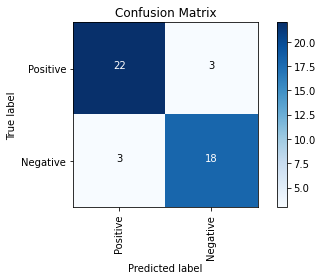

In [35]:
draw_confusion_matrix(y_test, y_test_pred5, ("Positive", "Negative"))

### Question 3.13
Rerun your SVM, but now modify your model parameter kernel to be `linear`. Again report your accuracy, precision, recall, F1 scores, and confusion matrix and plot the new ROC curve.  

In [36]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

svm = SVC(probability=True,kernel='linear')
svm.fit(x_train, y_train)
y_test_pred6 = svm.predict(x_test)
accuracy6 = accuracy_score(y_test, y_test_pred6)
precision6 =  precision_score(y_test, y_test_pred6)
recall6 = recall_score(y_test, y_test_pred6)
F1Score6 = f1_score(y_test, y_test_pred6)
print(f'{accuracy6=}\n{precision6=}\n{recall6=}\n{F1Score6=}')

accuracy6=0.8695652173913043
precision6=0.8571428571428571
recall6=0.8571428571428571
F1Score6=0.8571428571428571


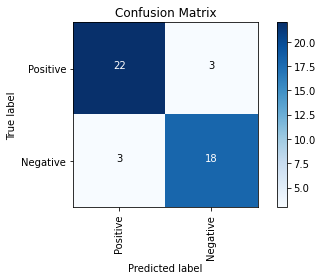

In [37]:
draw_confusion_matrix(y_test, y_test_pred6, ("Positive", "Negative"))

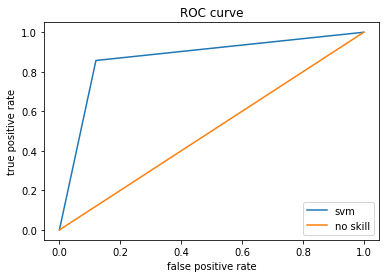

In [38]:
falsePositiveRate6, truePositiveRate6, _ = metrics.roc_curve(y_test, y_test_pred6)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve")
plt.plot(falsePositiveRate6,truePositiveRate6, label="svm")
plt.plot([0,1],[0,1], label="no skill")
plt.legend()
plt.show()

### Question 3.14
Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

**3.14 answer**  TODO CHECK

The linear SVM performs beter than a default SVM in nothing.

The linear parameter will fit a line to our model and it will perform the best when the data is almost linearly separable.

### Question 3.15
Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. How do they differ in how they try to find this boundary?


**3.15 answer**

- linear SVM
    - Uses support vectors to find a decision boundary. These vectors are created between the optimal dividing line and the datapoints closest to it.
- logistic regression
    - Uses an iterative method to maximize the likelihood function to get the coefficients of the logistic regression algorithm.

### Question 3.16
We also learned about linear regression in class. Why is linear regression not a suitable model for this classification task?

**3.16 answer**

Linear regression is not a suitable model for this classification task because linear regression is used on continuous numerical data and classification needs a model which can predict many different categorical variables which are discrete.

### Statistical Classification Methods
Now we'll explore a statistical classification method, the naive Bayes classifier.

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes' theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable. Bayes' theorem states the following relationship, given class variable $C_k$ and dependent feature vector $\bold{x} = [x_1, x_2, ..., x_n]^T$, $$P(C_k | \bold{x}) = \frac{P(C_k)P(\bold{x} | C_k)}{P(\bold{x})}$$

Note for our purposes, there are 2 possible classes (sick or not sick), so $k$ ranges from 1 to 2.

### Question 3.17
Implement a naive Bayes Classifier on the pipelined data. Use the `GaussianNB` model. For this model, simply use the default parameters. Report out the number of mislabeled points that result (i.e., both the false positives and false negatives), along with the accuracy, precision, recall, F1 Score and confusion matrix. Also, plot an ROC curve.

In [39]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_test_pred7 = gnb.predict(x_test)
accuracy7 = accuracy_score(y_test, y_test_pred7)
precision7 =  precision_score(y_test, y_test_pred7)
recall7 = recall_score(y_test, y_test_pred7)
F1Score7 = f1_score(y_test, y_test_pred7)
print(f'{accuracy7=}\n{precision7=}\n{recall7=}\n{F1Score7=}')

accuracy7=0.8260869565217391
precision7=0.8823529411764706
recall7=0.7142857142857143
F1Score7=0.7894736842105262


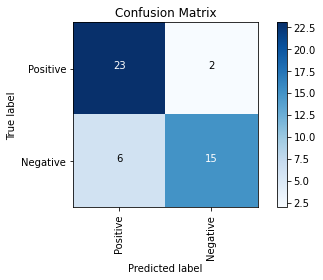

In [40]:
draw_confusion_matrix(y_test, y_test_pred7, ("Positive", "Negative"))

**3.17 answer**

FP = (bottom left of confusion matrix)

FN = (top right of ocnfusion matrix)


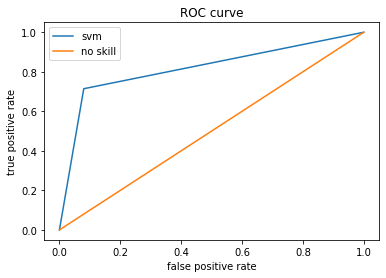

In [41]:
falsePositiveRate7, truePositiveRate7, _ = metrics.roc_curve(y_test, y_test_pred7)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve")
plt.plot(falsePositiveRate7,truePositiveRate7, label="svm")
plt.plot([0,1],[0,1], label="no skill")
plt.legend()
plt.show()

### Question 3.18
Discuss the observed results. What assumptions about our data are we making here and why might those be inaccurate?

**3.18 answer**

We are assuming that all of our features are independent.  This must be false.

We might have a confounding variable which is influencing some of the features.

## Part 4: Cross Validation and Model Selection
You've sampled a number of different classification techniques, leveraging nearest neighbors, linear classifiers, and statistical classifiers. You've also tweaked with a few parameters for those models to optimize performance. Based on these experiments you should have settled on a particular model that performs most optimally on this dataset. Before our work is done though, we want to ensure that our results are not the result of the random sampling of our data we did with the train-test split. To check this, we will conduct a K-fold cross validation of our top 2 performing models, assess their cumulative performance across folds (report accuracy, precision, recall, and F1 score), and determine the best model for our particular data.

### Question 4.1
Select your top 2 performing models and run a 10-Fold cross validation on both. Report your best performing model.


In [44]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from numpy import mean, std

score = {
    'accuracy' : make_scorer(accuracy_score),
    'precision' : make_scorer(precision_score),
    'recall' : make_scorer(recall_score),
    'f1_score' : make_scorer(f1_score)
}

crossValidation = KFold(n_splits=10, random_state=42, shuffle=True)

bestModel1 = LogisticRegression(solver="liblinear", max_iter=100, penalty="l1")
bestModel2 = SVC(probability=True,kernel='linear')


result1 = cross_validate(
    bestModel1,
    preparedData,
    sick,
    cv=crossValidation,
    scoring=score
)
result2 = cross_validate(
    bestModel2,
    preparedData,
    sick,
    cv=crossValidation,
    scoring=score
)

print(f"""
LogisticRegression(solver="liblinear", max_iter=100, penalty="l1")
{mean(result1['test_accuracy'])=}
{mean(result1['test_precision'])=}
{mean(result1['test_recall'])=}
{mean(result1['test_f1_score'])=}
""")

# accuracy4=0.8695652173913043
# precision4=0.8571428571428571
# recall4=0.8571428571428571
# F1Score4=0.8571428571428571

print(f"""
SVC(probability=True)
{mean(result2['test_accuracy'])=}
{mean(result2['test_precision'])=}
{mean(result2['test_recall'])=}
{mean(result2['test_f1_score'])=}
""")

# accuracy6=0.8695652173913043
# precision6=0.8571428571428571
# recall6=0.8571428571428571
# F1Score6=0.8571428571428571



LogisticRegression(solver="liblinear", max_iter=100, penalty="l1")
mean(result1['test_accuracy'])=0.8516129032258064
mean(result1['test_precision'])=0.8423023953171012
mean(result1['test_recall'])=0.8102033918094289
mean(result1['test_f1_score'])=0.8235476316394061


SVC(probability=True)
mean(result2['test_accuracy'])=0.8219354838709678
mean(result2['test_precision'])=0.8290285857932916
mean(result2['test_recall'])=0.7628638892067685
mean(result2['test_f1_score'])=0.7891805778363861



### Question 4.2
Discuss your results and why they differ slightly from what you got for the 2 models above.

**4.2 answer**

The results I got were worse in every category.

I think my results differ because k-fold cross validation removes the effects of noice from our trainging set which might have been influencing my model.

This means that the values I get from using k-fold cross validation will be a more accurate representation of what a good model would look like because it is close to an average of multiple runs of my best models.


### Question 4.3
Out of these 2 models, based on their scores for the 4 metrics, which one would you pick for this specific case of predicting if someone has heart disease or not?

I would pick `LogisticRegression(solver="liblinear", max_iter=100, penalty="l1")`  I think that it has a fairly good f1 score and it seems to be able predict much better than a random choice.  Furthermore the recall score for it is much higher which is much better for heart disease because we want to reduce the ammount of false negatives.  We do not want to falsely tell someone that they do not have heart problems when they actually do.